# Decord Memory Leak and Performance Benchmark

This notebook tests the decord library for potential memory leaks and benchmarks the video loading performance.

In [1]:
from decord import AudioReader, VideoReader, AVReader
import numpy as np
import os   
import shutil
from sources.videos import gather_video_paths
from sources.utils import AVReader
from decord import cpu, gpu

# Additional imports for memory tracking and benchmarking
import psutil
import gc
import time
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
import gc
# Import additional libraries we'll need
import av
import sys
from functools import partial

import cv2
import os
import shutil
import subprocess
import numpy as np
from typing import Tuple, Optional, Union, List, Dict, Any, Callable
from video_reader import PyVideoReader


In [2]:
videos_dir = '/home/mrwhite0racle/persist/data/vox2/test_filtered/'

In [3]:
video_paths = gather_video_paths(videos_dir)

In [4]:
print(f"Total number of videos: {len(video_paths)}")
print(f"Sample video path: {video_paths[0]}")

Total number of videos: 1663
Sample video path: /home/mrwhite0racle/persist/data/vox2/test_filtered/id00017/M6PYYNz3pac/00033.mp4


In [5]:
def read_av_random_clip_moviepy(
    video_path: str,
    num_frames: int = 16,
    audio_frames_per_video_frame: int = 1,
    audio_frame_padding: int = 0,
    target_sr: int = 16000,
    target_fps: float = 25.0,
    random_seed: Optional[int] = None,
):
    """
    Read a random clip of audio and video frames.
    Works by first selecting a random appropriate start frame, then reading the specified number of frames (1, N, H, W, C).
    It then selects the audio clip corresponding to the video frames + some extra padding frames on either side. This is 
    of shape (1, P + N + P, K) where P is the padding, N is the number of video frames, and K is the audio data shape per frame.
    if audio_frames_per_video_frame > 1, It then also creates a tensor of shape (1, N, F, K) where F = audio_frames_per_video_frame.
    Otherwise (1, N, 1, K) is returned in the case of audio_frames_per_video_frame = 1.
    
    The final audio and video tensors are returned.
    Args:
        video_path: Path to the video file.
        num_frames: Number of video frames to read.
        audio_frames_per_video_frame: Number of audio frames per video frame.
        audio_frame_padding: Padding for audio frames.
        target_sr: Target sample rate for the audio.
        target_fps: Target frames per second for the video.
        random_seed: Random seed for reproducibility (optional).
        
    Returns:
        Tuple of (frame_wise_audio, full_padded_audio, video_frames) where video_frames is a numpy array.
    """
    from moviepy import VideoFileClip
    # Set random seed if provided
    if random_seed is not None:
        np.random.seed(random_seed)
    # Load the video
    video = VideoFileClip(video_path).with_fps(target_fps)
    original_duration = video.duration
    total_frames = video.n_frames#int(original_duration * target_fps)
    
    # Calculate effective padding needed based on audio segmentation
    effective_padding = max(audio_frame_padding, (audio_frames_per_video_frame) // 2)

    # Make sure we have enough frames
    if total_frames < num_frames + 2 * effective_padding:
        raise ValueError(f"Video has only {total_frames} frames, but {num_frames + 2 * effective_padding} were requested (including effective padding)")

    # Adjust the range for start_idx to account for effective padding
    min_start_idx = effective_padding
    max_start_idx = total_frames - num_frames - effective_padding

    # Select a random start frame that allows for padding on both sides
    start_idx = np.random.randint(min_start_idx, max_start_idx) if max_start_idx > min_start_idx else min_start_idx
    end_idx = start_idx + num_frames
    
    # Convert to time
    video_start_time = start_idx / target_fps
    video_end_time = end_idx / target_fps
        
    # Extract video frames
    main_clip : VideoFileClip = video.subclipped(video_start_time, video_end_time)
    # Replace the video frame extraction with:
    frame_count = 0
    video_frames = []
    for frame in video.iter_frames(fps=target_fps, dtype='uint8'):
        if frame_count >= start_idx and frame_count < start_idx + num_frames:
            video_frames.append(frame)
        frame_count += 1
        if len(video_frames) == num_frames:
            break
        
    # Convert to numpy array
    video_frames = np.array(video_frames)
    
    audio_start_time = (start_idx - effective_padding) / target_fps
    audio_end_time = (end_idx + effective_padding) / target_fps
    num_audio_frames = num_frames + 2 * effective_padding
    audio_duration = audio_end_time - audio_start_time
    # Ensure we don't go out of bounds
    if audio_start_time < 0 or audio_end_time > original_duration:
        raise ValueError(f"Audio start time {audio_start_time} or end time {audio_end_time} is out of bounds for video duration {original_duration}")
    
    # Extract the subclip
    clip : VideoFileClip = video.subclipped(audio_start_time, audio_end_time)
    # Extract audio
    audio = clip.audio.with_fps(target_sr)
    audio_data = audio.to_soundarray()
    # Make sure len(audio_data) == (num_frames + 2 * effective_padding) * target_sr
    num_audio_samples_required = int(round(audio_duration * target_sr))
    if len(audio_data) < num_audio_samples_required:
        raise ValueError(f"Audio data length {len(audio_data)} is less than required {num_audio_samples_required}")
    audio_data = audio_data[:num_audio_samples_required]
    # Convert to mono if stereo
    if audio_data.ndim > 1 and audio_data.shape[1] > 1:
        audio_data = np.mean(audio_data, axis=1)
        
    # Close the clips
    clip.close()
    main_clip.close()
    video.close()
    
    # Reshape audio data
    audio_data = np.array(audio_data)   # This is just 1D
    
    # Calculate dimensions for audio
    audio_data_per_frame = int(round(target_sr / target_fps))
    # print(f"Audio {audio_duration * target_sr}->{num_audio_samples_required} data len {audio_data.shape},  shape: {num_audio_frames}, {audio_data_per_frame}")
    audio_data = audio_data.reshape(num_audio_frames, audio_data_per_frame)
    
    # Create frame-wise audio
    if audio_frames_per_video_frame > 1:
        raise NotImplementedError("Frame-wise audio extraction is not implemented yet.")
    else:
        # Extract the central part (for effective frames) and reshape to (1, N, 1, K)
        start_idx = effective_padding
        end_idx = start_idx + num_frames
        central_audio = audio_data[start_idx:end_idx]
        frame_wise_audio = central_audio.reshape(1, num_frames, 1, audio_data_per_frame)
        
    return frame_wise_audio, audio_data, video_frames


def read_av_random_clip_alt(
    video_path: str,
    num_frames: int = 16,
    audio_frames_per_video_frame: int = 1,
    audio_frame_padding: int = 0,
    target_sr: int = 16000,
    target_fps: float = 25.0,
    random_seed: Optional[int] = None,
):
    """
    Read a random clip of audio and video frames.
    Works by first selecting a random appropriate start frame, then reading the specified number of frames (1, N, H, W, C).
    It then selects the audio clip corresponding to the video frames + some extra padding frames on either side. This is 
    of shape (1, P + N + P, K) where P is the padding, N is the number of video frames, and K is the audio data shape per frame.
    if audio_frames_per_video_frame > 1, It then also creates a tensor of shape (1, N, F, K) where F = audio_frames_per_video_frame.
    Otherwise (1, N, 1, K) is returned in the case of audio_frames_per_video_frame = 1.
    
    The final audio and video tensors are returned.
    Args:
        video_path: Path to the video file.
        num_frames: Number of video frames to read.
        audio_frames_per_video_frame: Number of audio frames per video frame.
        audio_frame_padding: Padding for audio frames.
        target_sr: Target sample rate for the audio.
        target_fps: Target frames per second for the video.
        random_seed: Random seed for reproducibility (optional).
        
    Returns:
        Tuple of (frame_wise_audio, full_padded_audio, video_frames) where video_frames is a numpy array.
    """
    from moviepy import VideoFileClip, AudioFileClip
    # Set random seed if provided
    if random_seed is not None:
        np.random.seed(random_seed)
    # Load the video
    vr = PyVideoReader(video_path)
    info = vr.get_info()
    total_frames = int(info['frame_count'])
    
    # Calculate effective padding needed based on audio segmentation
    effective_padding = max(audio_frame_padding, (audio_frames_per_video_frame) // 2)

    # Make sure we have enough frames
    if total_frames < num_frames + 2 * effective_padding:
        raise ValueError(f"Video has only {total_frames} frames, but {num_frames + 2 * effective_padding} were requested (including effective padding)")

    # Adjust the range for start_idx to account for effective padding
    min_start_idx = effective_padding
    max_start_idx = total_frames - num_frames - effective_padding

    # Select a random start frame that allows for padding on both sides
    start_idx = np.random.randint(min_start_idx, max_start_idx) if max_start_idx > min_start_idx else min_start_idx
    end_idx = start_idx + num_frames
    
    video_frames = vr.decode(start_idx, end_idx)
    
    audio_start_time = (start_idx - effective_padding) / target_fps
    audio_end_time = (end_idx + effective_padding) / target_fps
    num_audio_frames = num_frames + 2 * effective_padding
    audio_duration = audio_end_time - audio_start_time
    
    assert audio_duration > 0, f"Audio duration {audio_duration} is not positive"
    assert audio_start_time >= 0, f"Audio start time {audio_start_time} is negative"
    
    # Extract the subclip
    audio_clip : AudioFileClip = VideoFileClip(video_path).audio.with_fps(target_sr).subclipped(audio_start_time, audio_end_time)
    audio_data = audio_clip.to_soundarray()
    # Make sure len(audio_data) == (num_frames + 2 * effective_padding) * target_sr
    num_audio_samples_required = int(round(audio_duration * target_sr))
    
    if len(audio_data) < num_audio_samples_required:
        raise ValueError(f"Audio data length {len(audio_data)} is less than required {num_audio_samples_required}")
    
    audio_data = audio_data[:num_audio_samples_required]
    # Convert to mono if stereo
    if audio_data.ndim > 1 and audio_data.shape[1] > 1:
        audio_data = np.mean(audio_data, axis=1)
        
    # Close the clips
    audio_clip.close()
    
    # Reshape audio data
    audio_data = np.array(audio_data)   # This is just 1D
    
    # Calculate dimensions for audio
    audio_data_per_frame = int(round(target_sr / target_fps))
    # print(f"Audio {audio_duration * target_sr}->{num_audio_samples_required} data len {audio_data.shape},  shape: {num_audio_frames}, {audio_data_per_frame}")
    audio_data = audio_data.reshape(num_audio_frames, audio_data_per_frame)
    
    # Create frame-wise audio
    if audio_frames_per_video_frame > 1:
        raise NotImplementedError("Frame-wise audio extraction is not implemented yet.")
    else:
        # Extract the central part (for effective frames) and reshape to (1, N, 1, K)
        start_idx = effective_padding
        end_idx = start_idx + num_frames
        central_audio = audio_data[start_idx:end_idx]
        frame_wise_audio = central_audio.reshape(1, num_frames, 1, audio_data_per_frame)
        
    return frame_wise_audio, audio_data, video_frames

def read_av_random_clip_pyav(
    video_path: str,
    num_frames: int = 16,
    audio_frames_per_video_frame: int = 1,
    audio_frame_padding: int = 0,
    target_sr: int = 16000,
    target_fps: float = 25.0,
    random_seed: Optional[int] = None,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Decodes a random video clip and its corresponding audio from `video_path`,
    padding audio by `audio_frame_padding` on each side in terms of video frames.
    Uses PyAV's built-in resampler to produce mono 16-bit audio at `target_sr`.

    Returns:
      (frame_wise_audio, full_padded_audio, video_frames)
        * frame_wise_audio: (1, num_frames, 1, audio_data_per_frame)
        * full_padded_audio: (num_frames + 2*padding, audio_data_per_frame)
        * video_frames: (num_frames, H, W, 3)
    """

    if random_seed is not None:
        np.random.seed(random_seed)

    # --- 1) Determine which video frames to read ---
    vr = PyVideoReader(video_path)
    total_frames = int(vr.get_info()["frame_count"])
    eff_pad = max(audio_frame_padding, audio_frames_per_video_frame // 2)
    needed_frames = num_frames + 2 * eff_pad
    if total_frames < needed_frames:
        raise ValueError(
            f"Video has only {total_frames} frames but needs {needed_frames} (with padding)."
        )

    min_start = eff_pad
    max_start = total_frames - num_frames - eff_pad
    start_idx = (
        np.random.randint(min_start, max_start)
        if max_start > min_start
        else min_start
    )
    end_idx = start_idx + num_frames

    # --- 2) Decode the chosen video frames ---
    video_frames = vr.decode(start_idx, end_idx)  # shape => (num_frames, H, W, 3)
    del vr

    # --- 3) Define audio time window ---
    audio_start_time = max(0.0, (start_idx - eff_pad) / target_fps)
    audio_end_time = (end_idx + eff_pad) / target_fps
    with av.open(video_path) as container:
        audio_stream = next((s for s in container.streams if s.type == "audio"), None)
        if audio_stream is None:
            raise ValueError("No audio stream found in the file.")

        # --- 4) Decode all audio, resample to s16 mono @ target_sr ---
        resampler = av.AudioResampler(format="s16", layout="mono", rate=target_sr)
        audio_segments = []
        segment_times = []
        for packet in container.demux(audio_stream):
            for frame in packet.decode():
                if frame.pts is None:
                    continue
                out = resampler.resample(frame)
                out = [out] if not isinstance(out, list) else out
                for oframe in out:
                    # Extract samples from the PyAV audio frame
                    arr = oframe.to_ndarray()   # shape: (1, samples) for mono
                    samples = arr.flatten().astype(np.int16)
                    start_t = float(oframe.pts * audio_stream.time_base)
                    end_t = start_t + oframe.samples / oframe.sample_rate
                    audio_segments.append(samples)
                    segment_times.append((start_t, end_t))
                    
        del resampler
    
    if not audio_segments:
        raise ValueError("No audio frames were decoded.")

    full_audio = np.concatenate(audio_segments, axis=0)
    seg_lens = [len(seg) for seg in audio_segments]
    offsets = np.cumsum([0] + seg_lens)

    # Helper: convert time -> sample index in full_audio
    def time_to_sample(t):
        if t <= segment_times[0][0]:
            return 0
        if t >= segment_times[-1][1]:
            return len(full_audio)
        for i, (st, ed) in enumerate(segment_times):
            if st <= t < ed:
                seg_offset = int(round((t - st) * audio_stream.rate))
                return offsets[i] + min(seg_offset, seg_lens[i] - 1)
        return len(full_audio)

    start_sample = time_to_sample(audio_start_time)
    end_sample = time_to_sample(audio_end_time)
    if end_sample <= start_sample:
        raise ValueError("No audio in the requested range.")

    # Slice out the desired portion
    sliced_audio = full_audio[start_sample:end_sample]

    # --- 5) Convert to float32 in [-1,1], pad or trim to the exact length ---
    # Overall expected sample count for the window
    needed_samples_window = int(round((audio_end_time - audio_start_time) * target_sr))
    if len(sliced_audio) < needed_samples_window:
        pad = needed_samples_window - len(sliced_audio)
        sliced_audio = np.pad(sliced_audio, (0, pad), "constant")
    else:
        sliced_audio = sliced_audio[:needed_samples_window]
    # Convert to float in [-1, 1]
    sliced_audio = sliced_audio.astype(np.float32) / 32768.0

    # We ultimately need (num_frames + 2*pad) * audio_data_per_frame
    num_audio_frames = num_frames + 2 * eff_pad
    audio_data_per_frame = int(round(target_sr / target_fps))
    needed_total_samples = num_audio_frames * audio_data_per_frame

    # Final pad/trim to expected shape
    if len(sliced_audio) < needed_total_samples:
        pad = needed_total_samples - len(sliced_audio)
        sliced_audio = np.pad(sliced_audio, (0, pad), "constant")
    else:
        sliced_audio = sliced_audio[:needed_total_samples]

    full_padded_audio = sliced_audio.reshape(num_audio_frames, audio_data_per_frame)

    # --- 6) Extract the clip's central audio & reshape for per-frame usage ---
    if audio_frames_per_video_frame > 1:
        raise NotImplementedError("Multiple audio frames per video frame not supported.")
    center = full_padded_audio[eff_pad:eff_pad + num_frames]
    frame_wise_audio = center.reshape(1, num_frames, 1, audio_data_per_frame)

    return frame_wise_audio, full_padded_audio, video_frames

# Create a registry of all random clip readers for easier function selection
CLIP_READERS = {
    'moviepy': read_av_random_clip_moviepy,
    'alt': read_av_random_clip_alt,
    'pyav': read_av_random_clip_pyav
}

In [6]:
def read_av(path: str, start: int=0, end: int = None, method='pyav'):
    """Generic read_av function that uses the selected implementation"""
    if method not in CLIP_READERS:
        raise ValueError(f"Unknown method: {method}. Available methods: {', '.join(CLIP_READERS.keys())}")
    
    _, a, v = CLIP_READERS[method](path)
    return a, v

## Basic Test

Let's first try loading a single video to ensure everything works correctly.

In [7]:
framewise, audio, video = read_av_random_clip_pyav(video_paths[0], audio_frame_padding=0)#, ctx=cpu(0))

print(f"Audio length: {len(audio)}")
print(f"Video shape: {video.shape}")

Audio length: 16
Video shape: (16, 256, 256, 3)


In [8]:
audio.shape

(16, 640)

In [ ]:
import torch
import torch.nn as nn

class ClapAudioEncoder(nn.Module):
    """
    A simple module that converts raw audio arrays to a CLAP embedding of shape [B, 1, 768].
    1) Runs the audio through a CLAP processor and model.
    2) (Optionally) linear-projects from CLAP's hidden_dim to out_dim if needed.
    """

    def __init__(
        self,
        clap_model_name: str = "laion/larger_clap_general",
        output_dim: int = 768,
        trainable_projection: bool = True,
    ):
        """
        Args:
            clap_model_name: The HuggingFace model name or path for the CLAP model+processor.
            output_dim: The desired final embedding dimension. Many CLAP models produce 512 or 768 by default.
            trainable_projection: If True, include a linear layer to project from CLAP dim to output_dim.
        """
        super().__init__()


        from transformers import ClapAudioModelWithProjection, ClapProcessor
        # 1. Load the CLAP model & processor
        self.processor = ClapProcessor.from_pretrained(clap_model_name)
        self.clap_model = ClapAudioModelWithProjection.from_pretrained(clap_model_name)
        self.clap_model.eval()

        # 2. Determine the dimension of CLAP's embedding
        #    Usually .audio_embeds is shape [B, 512] or [B, 768]. Let's read it from the config if possible.
        clap_hidden_dim = self.clap_model.config.projection_dim  # Commonly 512 or 768

        # 3. Optionally create a trainable projection from CLAP dimension -> output_dim
        if trainable_projection and (clap_hidden_dim != output_dim):
            self.proj = nn.Linear(clap_hidden_dim, output_dim, bias=True)
        else:
            self.proj = None
            # If the dims match, no projection needed.
        
        self.expected_num_tokens = 1

    @torch.no_grad()  # We can freeze CLAP's forward pass
    def encode_clap(self, audio_waveforms: torch.Tensor, sampling_rate: int = 48000) -> torch.Tensor:
        """
        Run the clap_model in inference mode to get [B, clap_hidden_dim] embeddings.
        audio_waveforms: shape [B, samples] or a list of shape [variable_len_samples] if you want a python list.
        sampling_rate: the sample rate for the waveforms.
        """
        # Call the ClapProcessor in a batched way. 
        # 1) If audio_waveforms is shape [B, T], we convert each row to an item for the processor.
        #    Alternatively, CLAP can handle lists of wave arrays. We'll do that approach:

        # if isinstance(audio_waveforms, torch.Tensor):
        #     # convert each row to CPU numpy. This can be memory heavy if T is large.
        #     # Alternatively, if audio is short or you do one sample at a time, this is fine.
        #     wave_list = [audio_waveforms[i].cpu().numpy() for i in range(audio_waveforms.size(0))]
        # else:
        #     # we assume it's already a list of numpy arrays
        #     wave_list = audio_waveforms

        inputs = self.processor(audios=audio_waveforms, sampling_rate=sampling_rate, return_tensors="pt")

        # Move inputs to same device as clap_model
        # We do not remove the @torch.no_grad to keep the forward pass non-trainable by default.
        # If you want to train CLAP, remove @torch.no_grad and remove the .eval() from constructor.
        for k, v in inputs.items():
            inputs[k] = v.to(self.clap_model.device)

        outputs = self.clap_model(**inputs)
        # Typically outputs.audio_embeds is [B, 512 or 768]
        # We just return that
        return outputs.audio_embeds

    def forward(self, wav: torch.Tensor, sampling_rate: int = 48000, *args, **kwargs) -> torch.Tensor:
        """
        Forward pass. Returns shape [B, 1, output_dim].
        """
        # 1. Get CLAP embedding (frozen by default, unless you remove @torch.no_grad from encode_clap)
        with torch.no_grad():
            clap_embeds = self.encode_clap(wav, sampling_rate=sampling_rate)  
            # shape e.g. [B, 512]

        # 2. If we have a trainable projection layer, apply it
        if self.proj is not None:
            clap_embeds = self.proj(clap_embeds)  # shape [B, output_dim]

        # 3. Return in shape [B, 1, output_dim]
        clap_embeds = clap_embeds.unsqueeze(1)  # [B, 1, output_dim]
        return clap_embeds
    

class Wav2Vec2AudioEncoder(nn.Module):
    """
    A module that converts raw audio arrays to a single wav2vec2-based embedding
    of shape [B, 1, output_dim].
    
    1) Runs the audio through a Wav2Vec2Processor and Wav2Vec2Model.
    2) Pools over time (mean pooling).
    3) Optionally projects to a specified output dimension.
    """

    def __init__(
        self,
        wav2vec2_model_name: str = "facebook/wav2vec2-base-960h",
        sampling_rate: int = 16000,
        freeze_wav2vec2: bool = True,
    ):
        from transformers import Wav2Vec2Model, Wav2Vec2Processor, Wav2Vec2Config

        """
        Args:
            wav2vec2_model_name: HF model name/path for the Wav2Vec2 model + processor.
            output_dim: final embedding dimension after pooling. If the Wav2Vec2 hidden size
                        is e.g. 768, you can keep it or project it to some other size.
            trainable_projection: if True, we add a linear layer to project from hidden_dim
                                  to output_dim. 
            freeze_wav2vec2: if True, we do not train Wav2Vec2 (use it as a frozen feature extractor).
        """
        super().__init__()

        # 1. Load the Wav2Vec2 processor and model
        self.processor = Wav2Vec2Processor.from_pretrained(wav2vec2_model_name)
        self.wav2vec2  = Wav2Vec2Model.from_pretrained(wav2vec2_model_name)

        if freeze_wav2vec2:
            self.wav2vec2.eval()
            for param in self.wav2vec2.parameters():
                param.requires_grad = False

        self.sampling_rate = sampling_rate

    def forward(
        self,
        wav: torch.Tensor,  # shape [B, samples]
        *args,
        **kwargs
    ) -> torch.Tensor:
        """
        Forward pass: returns shape [B, 1, output_dim].
        
        wav: float tensor of shape [B, T], T can vary per batch if you make a list of arrays,
                         but typically we handle the largest in the batch with padding. 
        sampling_rate: sample rate for the waveforms, must match what the processor expects (e.g. 16k).
        """
        assert wav.ndim == 2, f"Expecting [B, samples] input, got {wav.shape}"
        inputs = [self.processor(
            i,  # can be a list of 1D arrays or a 2D tensor
            sampling_rate=self.sampling_rate,
            return_tensors="pt",
            padding="longest",
            # truncation=True
        ) for i in wav]
        # Now the inputs are a list of dicts. We need to make 1 dict with all the values stacked.
        # Each dict can have multiple keys, e.g. "input_values", "attention_mask"
        device = self.wav2vec2.device
        inputs = {k: torch.cat([d[k].to(device) for d in inputs], dim=0) for k in inputs[0].keys()}

        # 2) Pass through Wav2Vec2Model
        # If we've set it to eval/freeze, this won't compute grads for Wav2Vec2
        with torch.no_grad():
            outputs = self.wav2vec2(**inputs)  # Wav2Vec2BaseModelOutput
        # outputs.last_hidden_state -> shape [B, T', hidden_dim]
        audio_embeds = outputs.last_hidden_state
        return audio_embeds


class WhisperAudioEncoder(nn.Module):
    """
    A module that converts raw audio arrays to a single Whisper-based embedding 
    of shape [B, 1, output_dim].

    1) Runs the audio through a WhisperProcessor, which creates log-mel spectrograms.
    2) Calls WhisperModel's encoder on the spectrogram features.
    3) Pools over the time dimension (mean pool).
    4) Optionally projects to a chosen output dimension.
    """

    def __init__(
        self,
        whisper_model_name: str = "openai/whisper-large-v2",
        output_dim: int = 768,
        trainable_projection: bool = True,
        freeze_whisper: bool = True,
    ):
        """
        Args:
            whisper_model_name: The HuggingFace model name or path (e.g., 'openai/whisper-large-v2').
            output_dim: Final embedding dimension after pooling. 
                        If Whisper's hidden size is e.g. 1280, you can reduce or keep it the same.
            trainable_projection: If True, we add a linear layer from hidden_dim -> output_dim.
            freeze_whisper: If True, we do not train the Whisper model (encoder) 
                            and use it as a frozen feature extractor.
        """
        super().__init__()
        from transformers import WhisperProcessor, WhisperModel, AutoFeatureExtractor
        
        # 1. Load processor & model
        # self.processor = WhisperProcessor.from_pretrained(whisper_model_name)
        self.model = WhisperModel.from_pretrained(whisper_model_name)
        self.processor = AutoFeatureExtractor.from_pretrained(whisper_model_name)

        # 2. Optionally freeze the entire model
        if freeze_whisper:
            self.model.eval()
            for param in self.model.parameters():
                param.requires_grad = False

        # 3. The "encoder" hidden size is typically in config.d_model
        hidden_dim = self.model.config.d_model  # e.g. 1280 for 'large-v2'

        # 4. Optionally create a projection from hidden_dim -> output_dim
        #    If the dims match, no projection needed.
        if trainable_projection and (hidden_dim != output_dim):
            print(f"Creating projection layer from {hidden_dim} -> {output_dim}")
            self.proj = nn.Linear(hidden_dim, output_dim, bias=True)
        else:
            self.proj = None
            
        self.expected_num_tokens = 1

    def forward(
        self,
        wav: torch.Tensor,  # shape [B, samples]
        sampling_rate: int = 16000
    ) -> torch.Tensor:
        """
        Forward pass. Returns shape [B, 1, output_dim].
        
        wav: float tensor [B, T], one waveform per row.
        sampling_rate: sample rate for the waveforms, typically 16k for Whisper (or 44100, etc.).
        """
        assert wav.ndim == 2, "Expecting [B, samples] input"
        inputs = [self.processor(
            i,  # can be a list of 1D arrays or a 2D tensor
            sampling_rate=sampling_rate,
            return_tensors="pt",
            # padding="longest",
            # truncation=True
        ) for i in wav]
        
        # Now the inputs are a list of dicts. We need to make 1 dict with all the values stacked.
        # Each dict can have multiple keys, e.g. "input_values", "attention_mask"
        device = self.model.device
        inputs = {k: torch.cat([d[k].to(device) for d in inputs], dim=0) for k in inputs[0].keys()}
        
        print(f"Inputs: {inputs['input_features'].shape}")

        # 2) Pass to Whisper encoder 
        #    The whisper model has an encoder & decoder. We'll only use the encoder here.
        #    (We want hidden states => set output_hidden_states=True if you want them all.)
        decoder_input_ids = torch.tensor([[1, 1]]) * self.model.config.decoder_start_token_id
        encoder_outputs = self.model(inputs['input_features'], decoder_input_ids=decoder_input_ids)
        # encoder_outputs.last_hidden_state -> shape [B, T's, hidden_dim]
        hidden_states = encoder_outputs.last_hidden_state

        # 3) Pool over time dimension (mean pool)
        #    shape => [B, hidden_dim]
        audio_embeds = hidden_states.mean(dim=1)

        # 4) Optionally apply the projection layer
        if self.proj is not None:
            audio_embeds = self.proj(audio_embeds)  # [B, output_dim]

        # 5) Final shape => [B, 1, output_dim]
        audio_embeds = audio_embeds.unsqueeze(1)

        return audio_embeds


In [63]:
# encoder = Wav2Vec2AudioEncoder(
#     wav2vec2_model_name="facebook/wav2vec2-base-960h",
#     sampling_rate=16000,
#     freeze_wav2vec2=True
# )

# encoder_clap = ClapAudioEncoder(
#     clap_model_name="laion/larger_clap_general",
#     output_dim=768,
#     trainable_projection=False
# )

encoder_whisper = WhisperAudioEncoder(
    whisper_model_name="openai/whisper-large-v2",
    output_dim=768,
    trainable_projection=False
)

In [65]:
out = encoder_whisper.forward(audio, sampling_rate=16000)

Inputs: torch.Size([16, 80, 3000])


In [18]:
%timeit out = encoder.forward(audio)

43.2 ms ± 404 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [66]:
out.shape

torch.Size([1, 1, 1280])

In [166]:
from moviepy import VideoFileClip
video = VideoFileClip(video_paths[0])

{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf58.76.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [256, 256], 'bitrate': 150, 'fps': 25.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 16000, 'bitrate': 62, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 8.0, 'bitrate': 218, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High)', 'video_size': [256, 256], 'video_bitrate': 150, 'video_fps': 25.0, 'default_audio_input_number': 0, 'default_

## Memory Leak Test

Now we'll monitor memory usage while repeatedly loading videos to check for leaks.

In [167]:
def get_memory_usage():
    """Get current memory usage in MB"""
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss / (1024 * 1024)  # Convert bytes to MB

def test_for_memory_leak(num_iterations=50, sample_size=10, method='pyav'):
    """Test for memory leaks by loading videos repeatedly"""
    memory_usage = []
    sample_paths = random.sample(video_paths, min(sample_size, len(video_paths)))
    
    # Record baseline memory usage
    gc.collect()
    baseline_memory = get_memory_usage()
    memory_usage.append(baseline_memory)
    
    print(f"Initial memory usage: {baseline_memory:.2f} MB")
    
    # Load videos repeatedly and track memory usage
    for i in tqdm(range(num_iterations)):
        path = random.choice(sample_paths)
        audio, video = read_av(path, method=method)
        
        # Force variable clearing
        del audio, video
        
        # Periodic garbage collection
        if i % 5 == 0:
            gc.collect()
        
        # Record memory
        memory_usage.append(get_memory_usage())
    
    # Final cleanup
    gc.collect()
    final_memory = get_memory_usage()
    memory_usage.append(final_memory)
    
    print(f"Final memory usage: {final_memory:.2f} MB")
    print(f"Memory change: {final_memory - baseline_memory:.2f} MB")
    
    return memory_usage

In [170]:
# Run the memory leak test
memory_usage = test_for_memory_leak(num_iterations=100, sample_size=20, method='alt')

Initial memory usage: 552.23 MB


  0%|          | 0/100 [00:00<?, ?it/s]

{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf58.76.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [256, 256], 'bitrate': 251, 'fps': 25.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 16000, 'bitrate': 62, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 4.29, 'bitrate': 317, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High)', 'video_size': [256, 256], 'video_bitrate': 251, 'video_fps': 25.0, 'default_audio_input_number': 0, 'default

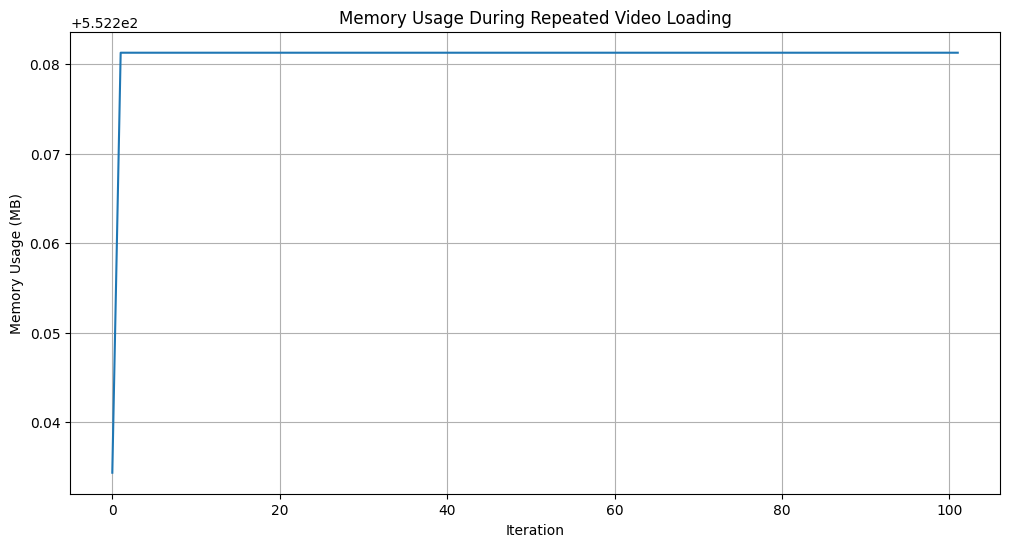

In [171]:
# Plot memory usage over iterations
plt.figure(figsize=(12, 6))
plt.plot(memory_usage)
plt.title('Memory Usage During Repeated Video Loading')
plt.xlabel('Iteration')
plt.ylabel('Memory Usage (MB)')
plt.grid(True)
plt.show()

## Memory Leak Test with Explicit Deletion of AVReader

Let's modify the test to explicitly delete the AVReader object.

In [11]:
def read_av_with_cleanup(path: str, start: int=0, end: int = None, ctx=cpu(0)):
    """Read audio-video with explicit cleanup"""
    vr = AVReader(path, ctx=ctx)
    audio, video = vr[start:end]
    video_np = video.asnumpy()  # Convert to numpy array
    audio_list = list(audio)  # Make a copy of audio data
    del vr  # Explicitly delete AVReader object
    return audio_list, video_np

def test_for_memory_leak_with_cleanup(num_iterations=50, sample_size=10):
    """Test for memory leaks with explicit cleanup"""
    memory_usage = []
    sample_paths = random.sample(video_paths, min(sample_size, len(video_paths)))
    
    # Record baseline memory usage
    gc.collect()
    baseline_memory = get_memory_usage()
    memory_usage.append(baseline_memory)
    
    print(f"Initial memory usage: {baseline_memory:.2f} MB")
    
    # Load videos repeatedly and track memory usage
    for i in tqdm(range(num_iterations)):
        path = random.choice(sample_paths)
        audio, video = read_av_with_cleanup(path)
        
        # Force variable clearing
        del audio, video
        
        # Periodic garbage collection
        if i % 5 == 0:
            gc.collect()
        
        # Record memory
        memory_usage.append(get_memory_usage())
    
    # Final cleanup
    gc.collect()
    final_memory = get_memory_usage()
    memory_usage.append(final_memory)
    
    print(f"Final memory usage: {final_memory:.2f} MB")
    print(f"Memory change: {final_memory - baseline_memory:.2f} MB")
    
    return memory_usage

In [12]:
# Run the memory leak test with explicit cleanup
memory_usage_with_cleanup = test_for_memory_leak_with_cleanup(num_iterations=100, sample_size=20)

Initial memory usage: 417.49 MB


  0%|          | 0/100 [00:00<?, ?it/s]

Final memory usage: 575.48 MB
Memory change: 157.99 MB


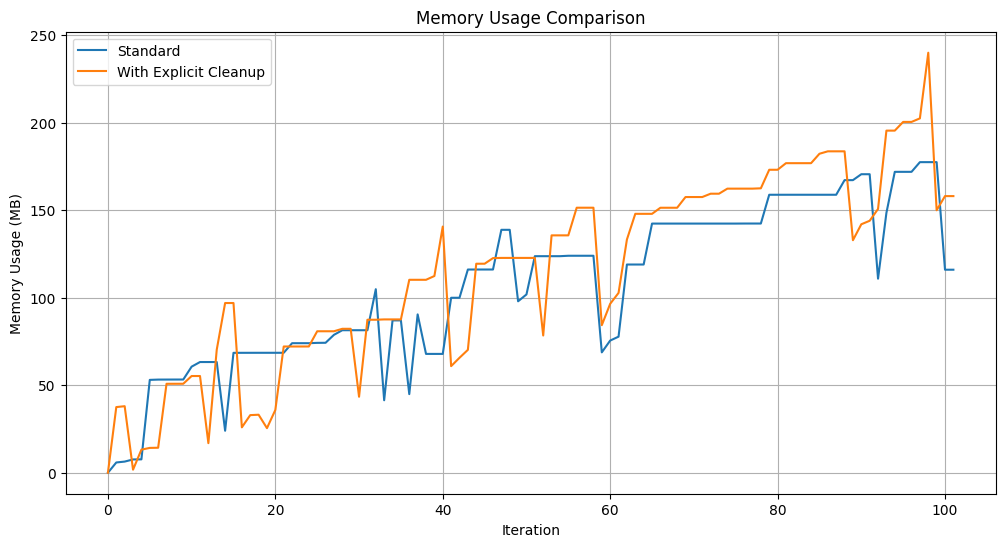

In [14]:
# Plot memory usage over iterations for both approaches
plt.figure(figsize=(12, 6))
plt.plot([i - memory_usage[0] for i in memory_usage], label='Standard')
plt.plot([i - memory_usage_with_cleanup[0] for i in memory_usage_with_cleanup], label='With Explicit Cleanup')
plt.title('Memory Usage Comparison')
plt.xlabel('Iteration')
plt.ylabel('Memory Usage (MB)')
plt.legend()
plt.grid(True)
plt.show()

## Performance Benchmark

Let's measure the performance of loading videos at random.

In [36]:
def benchmark_video_loading(num_videos=50, method='pyav'):
    """Benchmark video loading performance"""
    # Select random videos to load
    selected_paths = random.sample(video_paths, min(num_videos, len(video_paths)))
    
    load_times = []
    video_sizes = []
    
    print(f"Benchmarking {method} method...")
    
    for path in tqdm(selected_paths):
        start_time = time.time()
        
        # Load the video using specified method
        audio, video = read_av(path, method=method)
        end_time = time.time()
        
        # Calculate and store metrics
        load_time = end_time - start_time
        load_times.append(load_time)
        
        # Get video size in MB
        video_size = video.nbytes / (1024 * 1024)  # Convert bytes to MB
        video_sizes.append(video_size)
        
        # Cleanup
        del audio, video
        if len(load_times) % 10 == 0:
            gc.collect()
    
    # Calculate statistics
    avg_time = sum(load_times) / len(load_times)
    avg_size = sum(video_sizes) / len(video_sizes)
    avg_speed = sum(video_sizes) / sum(load_times)  # MB/s
    
    print(f"Average load time: {avg_time:.4f} seconds")
    print(f"Average video size: {avg_size:.2f} MB")
    print(f"Average loading speed: {avg_speed:.2f} MB/s")
    
    return load_times, video_sizes

Benchmarking pyav method...


  0%|          | 0/30 [00:00<?, ?it/s]

Average load time: 0.0964 seconds
Average video size: 3.00 MB
Average loading speed: 31.11 MB/s
Benchmarking alt method...


  0%|          | 0/30 [00:00<?, ?it/s]

{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf58.76.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [256, 256], 'bitrate': 194, 'fps': 25.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 16000, 'bitrate': 62, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 4.54, 'bitrate': 262, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High)', 'video_size': [256, 256], 'video_bitrate': 194, 'video_fps': 25.0, 'default_audio_input_number': 0, 'default

/tmp/ipykernel_843722/2816294578.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([pyav_times, alt_times], labels=['pyav', 'alt'])


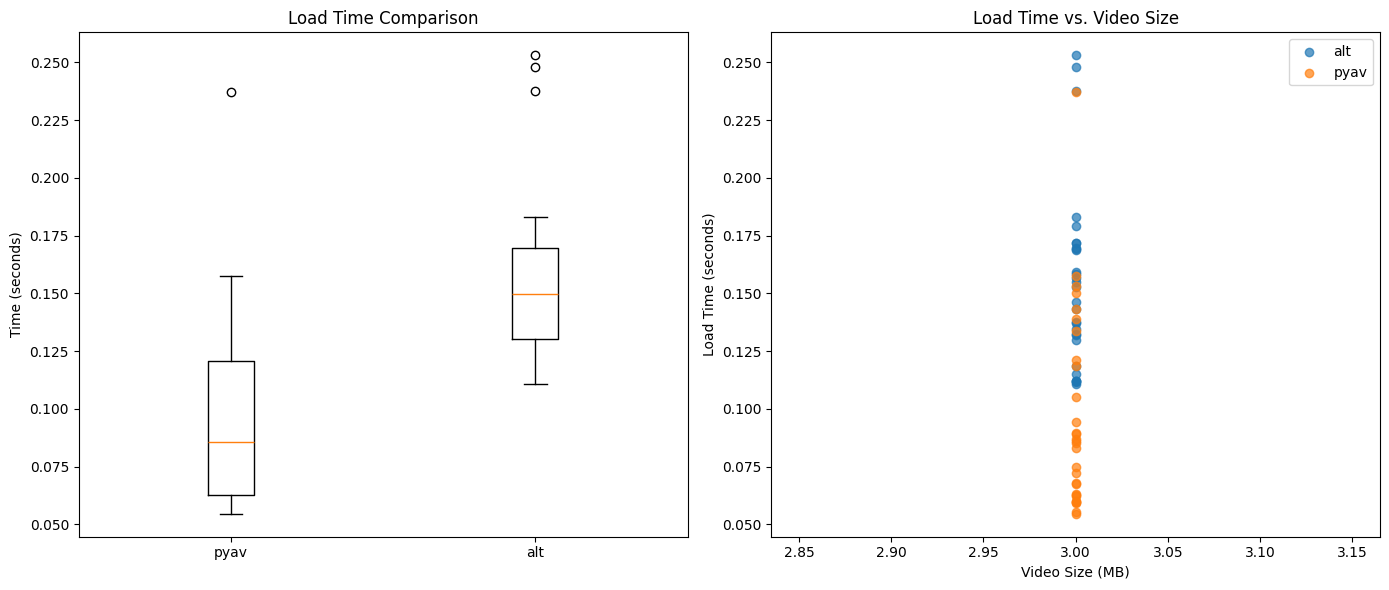

In [40]:
# Benchmark standard method
pyav_times, pyav_sizes = benchmark_video_loading(num_videos=30, method='pyav')
alt_times, alt_sizes = benchmark_video_loading(num_videos=30, method='alt')

# Plot performance comparison
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.boxplot([pyav_times, alt_times], labels=['pyav', 'alt'])
plt.title('Load Time Comparison')
plt.ylabel('Time (seconds)')

plt.subplot(1, 2, 2)
plt.scatter(alt_sizes, alt_times, alpha=0.7, label='alt')
plt.scatter(pyav_sizes, pyav_times, alpha=0.7, label='pyav')
plt.title('Load Time vs. Video Size')
plt.xlabel('Video Size (MB)')
plt.ylabel('Load Time (seconds)')
plt.legend()

plt.tight_layout()
plt.show()

In [41]:
def benchmark_clip_reader(
    reader_fn: Callable,
    reader_name: str,
    video_path: str,
    num_iterations: int = 5,
    base_params: Dict[str, Any] = None,
    base_random_seed: int = 42
):
    """Benchmark a single clip reader implementation"""
    results = {
        'memory_usage': [],
        'times': [],
        'errors': 0
    }
    
    # Default parameters
    if base_params is None:
        base_params = {
            'video_path': video_path,
            'num_frames': 16,
            'audio_frames_per_video_frame': 1,
            'audio_frame_padding': 2,
            'target_sr': 16000,
            'target_fps': 25.0
        }
    
    print(f"Benchmarking {reader_name}...")
    for i in tqdm(range(num_iterations)):
        # Prepare parameters with unique random seed
        params = base_params.copy()
        params['random_seed'] = base_random_seed + i
        
        # Measure memory before
        gc.collect()
        memory_before = get_memory_usage()
        
        # Measure time
        start_time = time.time()
        try:
            frame_wise_audio, full_padded_audio, video_frames = reader_fn(**params)
            
            # Record stats
            end_time = time.time()
            results['times'].append(end_time - start_time)
            
            # Clean up and measure memory after
            del frame_wise_audio, full_padded_audio, video_frames
            gc.collect()
            memory_after = get_memory_usage()
            results['memory_usage'].append(memory_after - memory_before)
        except Exception as e:
            results['errors'] += 1
            print(f"Error with {reader_name}: {e}")
    
    return results

def benchmark_all_clip_readers(
    video_path: str, 
    readers: List[str] = None, 
    num_iterations: int = 5, 
    params: Dict[str, Any] = None
):
    """Benchmark multiple clip reader implementations"""
    if readers is None:
        readers = list(CLIP_READERS.keys())
    
    # Run benchmarks for each reader
    all_results = {}
    base_random_seed = 42
    
    for reader_name in readers:
        if reader_name not in CLIP_READERS:
            print(f"Unknown reader: {reader_name}. Skipping...")
            continue
            
        reader_fn = CLIP_READERS[reader_name]
        all_results[reader_name] = benchmark_clip_reader(
            reader_fn, 
            reader_name, 
            video_path, 
            num_iterations,
            params,
            base_random_seed
        )
    
    # Print statistics
    print("\nBenchmark Results:")
    for reader_name, results in all_results.items():
        if results['times']:
            avg_time = sum(results['times']) / len(results['times'])
            avg_memory = sum(results['memory_usage']) / len(results['memory_usage'])
            print(f"{reader_name} method:")
            print(f"  Average time: {avg_time:.4f} seconds")
            print(f"  Average memory change: {avg_memory:.2f} MB")
            print(f"  Errors: {results['errors']}")
        else:
            print(f"{reader_name} method: No successful runs")
            
    return all_results

In [44]:
# Run unified benchmark on a sample of videos
test_videos = random.sample(video_paths, 5)
all_benchmark_results = {}

for i, video_path in enumerate(test_videos):
    print(f"\nTesting video {i+1}/{len(test_videos)}: {os.path.basename(video_path)}")
    print("-" * 60)
    
    try:
        all_benchmark_results[video_path] = benchmark_all_clip_readers(
            video_path=video_path,
            readers=['alt', 'moviepy', 'pyav'],
            num_iterations=20
        )
    except Exception as e:
        print(f"Failed to benchmark {os.path.basename(video_path)}: {e}")


Testing video 1/5: 00250.mp4
------------------------------------------------------------
Benchmarking alt...


  0%|          | 0/20 [00:00<?, ?it/s]

{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf58.76.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [256, 256], 'bitrate': 153, 'fps': 25.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 16000, 'bitrate': 61, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 9.41, 'bitrate': 220, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High)', 'video_size': [256, 256], 'video_bitrate': 153, 'video_fps': 25.0, 'default_audio_input_number': 0, 'default

  0%|          | 0/20 [00:00<?, ?it/s]

{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf58.76.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [256, 256], 'bitrate': 153, 'fps': 25.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 16000, 'bitrate': 61, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 9.41, 'bitrate': 220, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High)', 'video_size': [256, 256], 'video_bitrate': 153, 'video_fps': 25.0, 'default_audio_input_number': 0, 'default

  0%|          | 0/20 [00:00<?, ?it/s]


Benchmark Results:
alt method:
  Average time: 0.1320 seconds
  Average memory change: 0.01 MB
  Errors: 0
moviepy method:
  Average time: 0.2501 seconds
  Average memory change: -0.00 MB
  Errors: 0
pyav method:
  Average time: 0.0670 seconds
  Average memory change: 0.00 MB
  Errors: 0

Testing video 2/5: 00223.mp4
------------------------------------------------------------
Benchmarking alt...


  0%|          | 0/20 [00:00<?, ?it/s]

{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf58.76.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [256, 256], 'bitrate': 232, 'fps': 25.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 16000, 'bitrate': 61, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 7.36, 'bitrate': 299, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High)', 'video_size': [256, 256], 'video_bitrate': 232, 'video_fps': 25.0, 'default_audio_input_number': 0, 'default

  0%|          | 0/20 [00:00<?, ?it/s]

{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf58.76.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [256, 256], 'bitrate': 232, 'fps': 25.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 16000, 'bitrate': 61, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 7.36, 'bitrate': 299, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High)', 'video_size': [256, 256], 'video_bitrate': 232, 'video_fps': 25.0, 'default_audio_input_number': 0, 'default

  0%|          | 0/20 [00:00<?, ?it/s]


Benchmark Results:
alt method:
  Average time: 0.1347 seconds
  Average memory change: 0.00 MB
  Errors: 0
moviepy method:
  Average time: 0.2314 seconds
  Average memory change: 0.00 MB
  Errors: 0
pyav method:
  Average time: 0.0641 seconds
  Average memory change: 0.00 MB
  Errors: 0

Testing video 3/5: 00064.mp4
------------------------------------------------------------
Benchmarking alt...


  0%|          | 0/20 [00:00<?, ?it/s]

{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf58.76.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [256, 256], 'bitrate': 230, 'fps': 25.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 16000, 'bitrate': 61, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 14.98, 'bitrate': 296, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High)', 'video_size': [256, 256], 'video_bitrate': 230, 'video_fps': 25.0, 'default_audio_input_number': 0, 'defaul

  0%|          | 0/20 [00:00<?, ?it/s]

{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf58.76.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [256, 256], 'bitrate': 230, 'fps': 25.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 16000, 'bitrate': 61, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 14.98, 'bitrate': 296, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High)', 'video_size': [256, 256], 'video_bitrate': 230, 'video_fps': 25.0, 'default_audio_input_number': 0, 'defaul

  0%|          | 0/20 [00:00<?, ?it/s]


Benchmark Results:
alt method:
  Average time: 0.1347 seconds
  Average memory change: 0.00 MB
  Errors: 0
moviepy method:
  Average time: 0.2676 seconds
  Average memory change: 0.00 MB
  Errors: 0
pyav method:
  Average time: 0.0674 seconds
  Average memory change: 0.00 MB
  Errors: 0

Testing video 4/5: 00108.mp4
------------------------------------------------------------
Benchmarking alt...


  0%|          | 0/20 [00:00<?, ?it/s]

{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf58.76.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [256, 256], 'bitrate': 196, 'fps': 25.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 16000, 'bitrate': 61, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 29.95, 'bitrate': 261, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High)', 'video_size': [256, 256], 'video_bitrate': 196, 'video_fps': 25.0, 'default_audio_input_number': 0, 'defaul

  0%|          | 0/20 [00:00<?, ?it/s]

{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf58.76.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [256, 256], 'bitrate': 196, 'fps': 25.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 16000, 'bitrate': 61, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 29.95, 'bitrate': 261, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High)', 'video_size': [256, 256], 'video_bitrate': 196, 'video_fps': 25.0, 'default_audio_input_number': 0, 'defaul

  0%|          | 0/20 [00:00<?, ?it/s]


Benchmark Results:
alt method:
  Average time: 0.1397 seconds
  Average memory change: 0.00 MB
  Errors: 0
moviepy method:
  Average time: 0.3064 seconds
  Average memory change: 0.00 MB
  Errors: 0
pyav method:
  Average time: 0.0694 seconds
  Average memory change: 0.00 MB
  Errors: 0

Testing video 5/5: 00241.mp4
------------------------------------------------------------
Benchmarking alt...


  0%|          | 0/20 [00:00<?, ?it/s]

{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf58.76.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [256, 256], 'bitrate': 184, 'fps': 25.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 16000, 'bitrate': 62, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 5.7, 'bitrate': 251, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High)', 'video_size': [256, 256], 'video_bitrate': 184, 'video_fps': 25.0, 'default_audio_input_number': 0, 'default_

  0%|          | 0/20 [00:00<?, ?it/s]

{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf58.76.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [256, 256], 'bitrate': 184, 'fps': 25.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 16000, 'bitrate': 62, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 5.7, 'bitrate': 251, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High)', 'video_size': [256, 256], 'video_bitrate': 184, 'video_fps': 25.0, 'default_audio_input_number': 0, 'default_

  0%|          | 0/20 [00:00<?, ?it/s]


Benchmark Results:
alt method:
  Average time: 0.1262 seconds
  Average memory change: 0.30 MB
  Errors: 0
moviepy method:
  Average time: 0.2046 seconds
  Average memory change: -0.30 MB
  Errors: 0
pyav method:
  Average time: 0.0597 seconds
  Average memory change: 0.00 MB
  Errors: 0


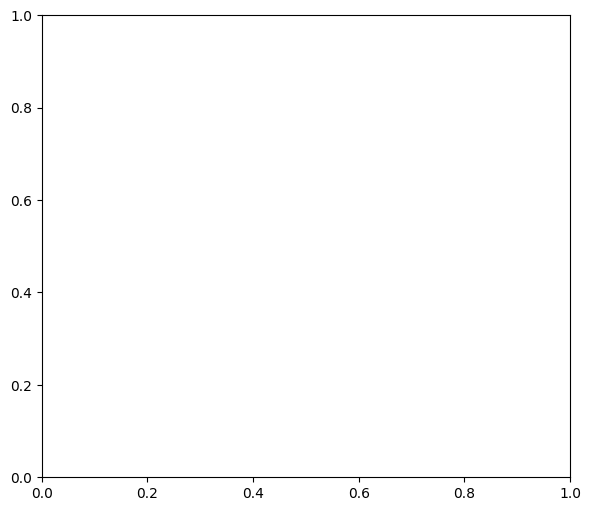

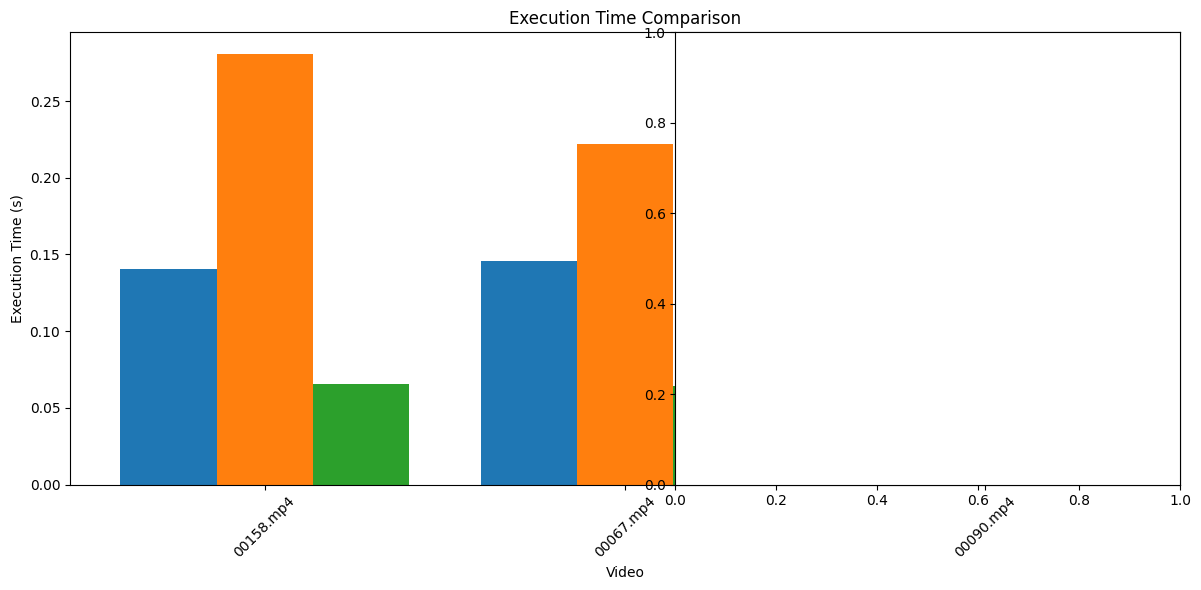

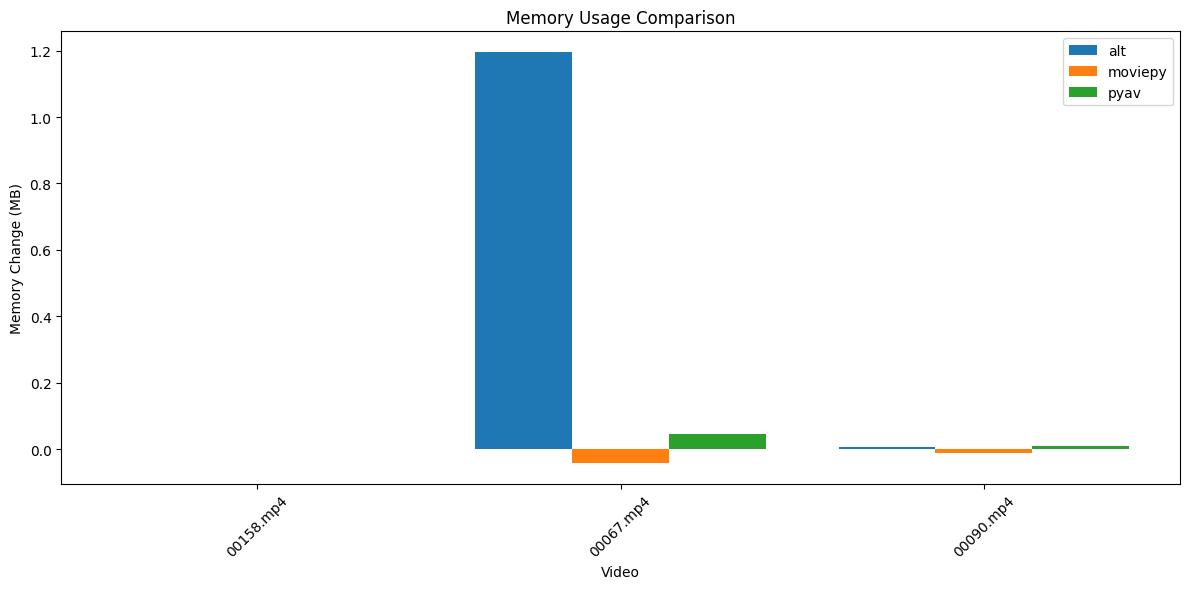

In [43]:
def plot_benchmark_results(results_dict, metric='times'):
    """Plot benchmark results for comparison"""
    plt.figure(figsize=(12, 6))
    
    # Prepare data for plotting
    methods = list(next(iter(results_dict.values())).keys())
    videos = [os.path.basename(path) for path in results_dict.keys()]
    
    # Create bar position indices
    x = np.arange(len(videos))
    width = 0.8 / len(methods)
    
    # Plot bars for each method
    for i, method in enumerate(methods):
        values = []
        for video_path in results_dict:
            result = results_dict[video_path][method]
            if metric in result and result[metric]:
                values.append(np.mean(result[metric]))
            else:
                values.append(0)  # No data = 0
                
        plt.bar(
            x + (i - len(methods)/2 + 0.5) * width, 
            values, 
            width, 
            label=method
        )
    
    # Set labels and title
    metric_labels = {
        'times': 'Execution Time (s)',
        'memory_usage': 'Memory Change (MB)',
    }
    plt.xlabel('Video')
    plt.ylabel(metric_labels.get(metric, metric))
    plt.title(f'{metric_labels.get(metric, metric)} Comparison')
    plt.xticks(x, videos, rotation=45)
    plt.legend()
    plt.tight_layout()
    
# Plot benchmark results
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plot_benchmark_results(all_benchmark_results, 'times')
plt.title('Execution Time Comparison')

plt.subplot(1, 2, 2)
plot_benchmark_results(all_benchmark_results, 'memory_usage')
plt.title('Memory Usage Comparison')

plt.tight_layout()
plt.show()

## Unified Output Comparison Testing

Let's compare the outputs of all three implementations to ensure they produce similar results with the same inputs.

In [137]:
def compare_all_outputs(video_path, random_seed=42, params=None):
    """Compare outputs from all reader implementations"""
    print(f"Testing outputs for {os.path.basename(video_path)} with seed {random_seed}")
    
    # Default parameters
    if params is None:
        params = {
            'video_path': video_path,
            'num_frames': 16,
            'audio_frames_per_video_frame': 1,
            'audio_frame_padding': 2,
            'target_sr': 16000,
            'target_fps': 25.0,
            'random_seed': random_seed
        }
    else:
        # Ensure params has the necessary keys
        params = params.copy()
        params['video_path'] = video_path
        params['random_seed'] = random_seed
    
    # Get outputs from all implementations
    results = {}
    for name, reader_fn in CLIP_READERS.items():
        try:
            print(f"\nRunning {name} implementation...")
            frame_wise, padded, video = reader_fn(**params)
            results[name] = {
                'frame_wise': frame_wise,
                'padded': padded,
                'video': video
            }
            print(f"  Frame-wise shape: {frame_wise.shape}")
            print(f"  Padded shape: {padded.shape}")
            print(f"  Video shape: {video.shape}")
        except Exception as e:
            print(f"Error with {name}: {e}")
    
    # Compare all implementations
    print("\nCross-implementation comparisons:")
    comparison_results = {}
    methods = list(results.keys())
    
    for i in range(len(methods)):
        for j in range(i+1, len(methods)):
            method1, method2 = methods[i], methods[j]
            comparison_key = f"{method1}_vs_{method2}"
            print(f"\nComparing {method1} vs {method2}:")
            
            # Compare video frames
            video1 = results[method1]['video']
            video2 = results[method2]['video']
            
            if video1.shape == video2.shape:
                video_diff = np.abs(video1.astype(np.float32) - video2.astype(np.float32))
                max_video_diff = np.max(video_diff)
                mean_video_diff = np.mean(video_diff)
                print(f"  Video frames - max diff: {max_video_diff:.4f}, mean diff: {mean_video_diff:.4f}. Video ranges: ({np.max(video1)}, {np.min(video1)}) vs ({np.max(video2)}, {np.min(video2)})")
                video_match = max_video_diff < 5.0  # Allow small differences
            else:
                print(f"  Video shapes don't match: {video1.shape} vs {video2.shape}")
                video_match = False
            
            # Compare frame-wise audio
            audio1 = results[method1]['frame_wise']
            audio2 = results[method2]['frame_wise']
            
            if audio1.shape == audio2.shape:
                audio_diff = np.abs(audio1 - audio2)
                max_audio_diff = np.max(audio_diff)
                mean_audio_diff = np.mean(audio_diff)
                print(f"  Audio - max diff: {max_audio_diff:.4f}, mean diff: {mean_audio_diff:.4f}")
                audio_match = mean_audio_diff < 0.01  # Allow small differences
            else:
                print(f"  Audio shapes don't match: {audio1.shape} vs {audio2.shape}")
                audio_match = False
                
            # Store comparison results
            comparison_results[comparison_key] = {
                'video_match': video_match,
                'audio_match': audio_match,
                'video_diff': {'max': max_video_diff if video_match else None, 'mean': mean_video_diff if video_match else None},
                'audio_diff': {'max': max_audio_diff if audio_match else None, 'mean': mean_audio_diff if audio_match else None},
            }
            
            print(f"  Result: {'✓' if video_match and audio_match else '✗'}")
            
    return results, comparison_results

def visualize_all_implementations(result):
    """Visualize sample frames and audio from all implementations"""
    if not result or not result.get('outputs'):
        print("No results available to visualize")
        return
    
    # Set up visualization
    outputs = result['outputs']
    methods = list(outputs.keys())
    n_methods = len(methods)
    
    # Create grid of plots for video frames
    plt.figure(figsize=(15, 5 * n_methods))
    
    for i, method in enumerate(methods):
        # Get data
        try:
            video_frames = outputs[method]['video']
            audio_data = outputs[method]['frame_wise'].reshape(-1)
            
            # Video frame
            plt.subplot(n_methods, 2, i*2+1)
            plt.title(f"First video frame - {method}")
            plt.imshow(video_frames[0])
            plt.axis('off')
            
            # Audio waveform
            plt.subplot(n_methods, 2, i*2+2)
            plt.title(f"Audio waveform sample - {method}")
            plt.plot(audio_data[:1000])
            plt.xlabel('Sample index')
            plt.ylabel('Amplitude')
        except Exception as e:
            plt.subplot(n_methods, 2, i*2+1)
            plt.text(0.5, 0.5, f"Error visualizing {method}: {e}", 
                     ha='center', va='center', transform=plt.gca().transAxes)
            plt.axis('off')
            
    plt.tight_layout()
    plt.show()
    
    # Plot differences between implementations
    if len(methods) > 1:
        plt.figure(figsize=(15, 5 * (n_methods-1)))
        plot_idx = 1
        
        for i in range(len(methods)):
            for j in range(i+1, len(methods)):
                method1, method2 = methods[i], methods[j]
                try:
                    # Get video frames
                    video1 = outputs[method1]['video'][0]
                    video2 = outputs[method2]['video'][0]
                    
                    if video1.shape == video2.shape:
                        # Compute difference
                        diff = np.abs(video1.astype(np.float32) - video2.astype(np.float32))
                        
                        plt.subplot(n_methods-1, 2, plot_idx)
                        plt.title(f"Frame difference: {method1} vs {method2}")
                        plt.imshow(diff, cmap='hot')
                        plt.colorbar(label='Absolute Difference')
                        plt.axis('off')
                        
                        # Compare audio
                        audio1 = outputs[method1]['frame_wise'].reshape(-1)[:1000]
                        audio2 = outputs[method2]['frame_wise'].reshape(-1)[:1000]
                        
                        plt.subplot(n_methods-1, 2, plot_idx+1)
                        plt.title(f"Audio comparison: {method1} vs {method2}")
                        plt.plot(audio1, label=method1)
                        plt.plot(audio2, label=method2)
                        plt.legend()
                        
                        plot_idx += 2
                except Exception as e:
                    plt.subplot(n_methods-1, 1, plot_idx)
                    plt.text(0.5, 0.5, f"Error comparing {method1} vs {method2}: {e}", 
                             ha='center', va='center', transform=plt.gca().transAxes)
                    plt.axis('off')
                    plot_idx += 1
        
        plt.tight_layout()
        plt.show()


TESTING 00150.mp4
Testing outputs for 00150.mp4 with seed 42

Running moviepy implementation...
{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf58.76.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [256, 256], 'bitrate': 177, 'fps': 25.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 16000, 'bitrate': 62, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 4.1, 'bitrate': 244, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High)', 'video_size'

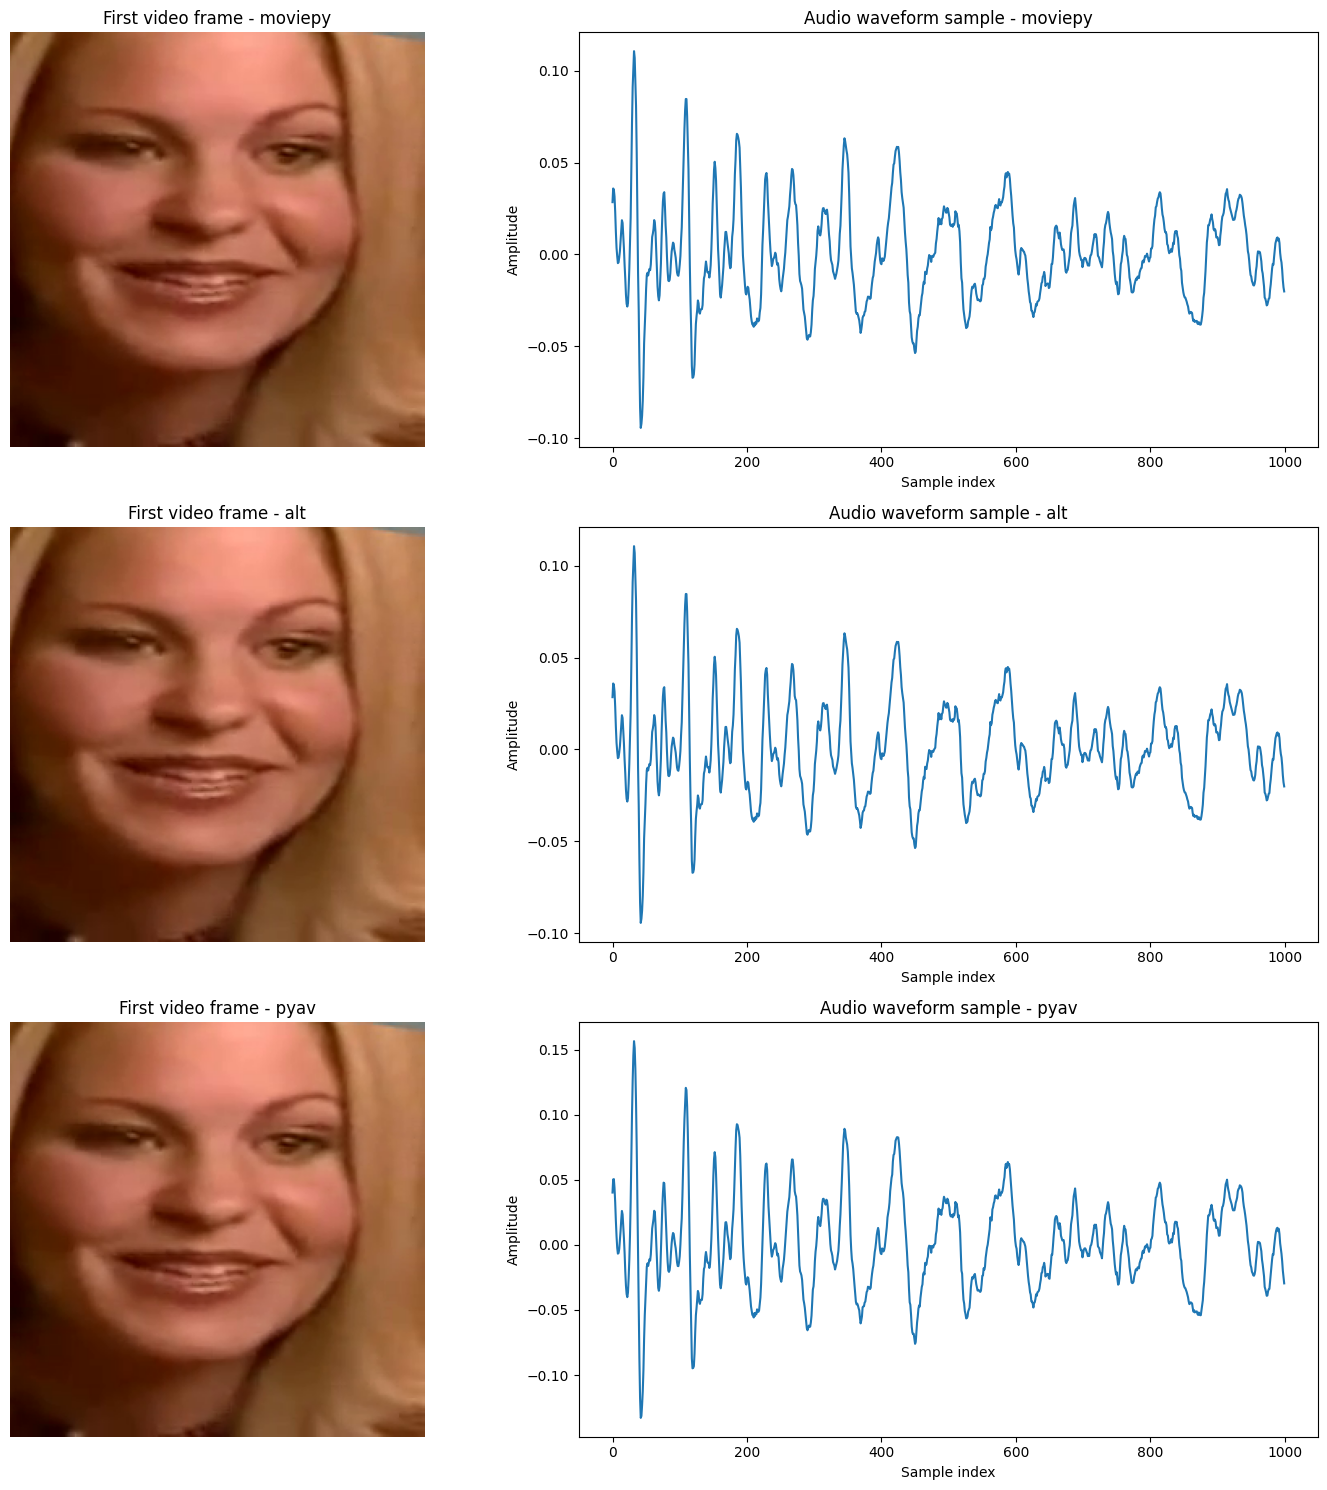

ValueError: num must be an integer with 1 <= num <= 2, not 5

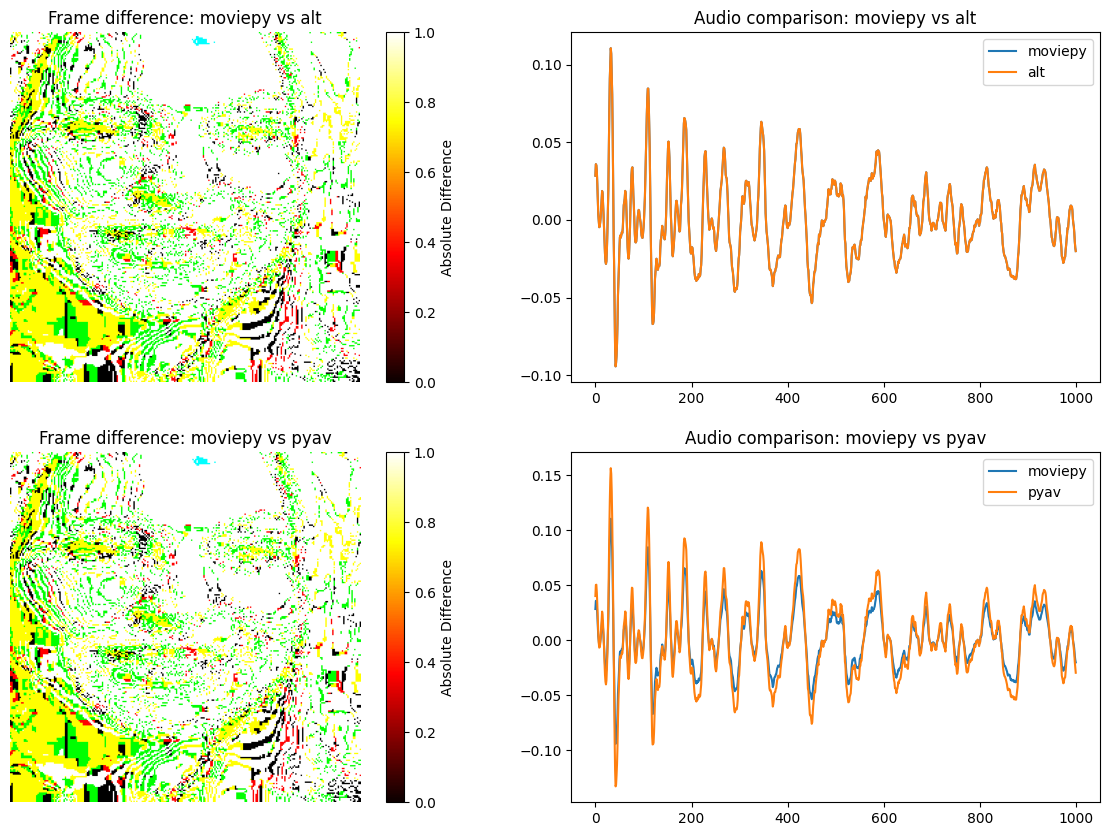

In [138]:
# Test a few videos with different seeds
test_videos = random.sample(video_paths, 2)
all_comparison_results = {}

for video_path in test_videos:
    print(f"\nTESTING {os.path.basename(video_path)}")
    print("=" * 60)
    
    for seed in [42, 123]:
        result_key = f"{os.path.basename(video_path)}_{seed}"
        try:
            outputs, comparisons = compare_all_outputs(video_path, random_seed=seed)
            all_comparison_results[result_key] = {
                'outputs': outputs,
                'comparisons': comparisons
            }
        except Exception as e:
            print(f"Failed comparison test: {e}")
            
# Visualize comparison for the first test case
if all_comparison_results:
    first_key = list(all_comparison_results.keys())[0]
    print(f"Visualizing results for: {first_key}")
    visualize_all_implementations(all_comparison_results[first_key])

## Parameter Impact Test

Let's evaluate how different parameters affect the performance of each implementation.

In [56]:
av.time_base.AVR_TIME_BASE

AttributeError: 'int' object has no attribute 'AVR_TIME_BASE'

In [60]:
def test_parameter_impacts(video_path, methods=None):
    """Test how different parameters affect performance across implementations"""
    if methods is None:
        methods = list(CLIP_READERS.keys())
    
    # Base parameters
    base_params = {
        'video_path': video_path,
        'num_frames': 16,
        'audio_frames_per_video_frame': 1,
        'audio_frame_padding': 2,
        'target_sr': 16000,
        'target_fps': 25.0,
        'random_seed': 42
    }
    
    # Parameter variations to test
    param_variations = {
        'num_frames': [8, 16, 32, 64],
        'target_sr': [8000, 16000, 32000, 44100],
        'audio_frame_padding': [0, 2, 4, 8]
    }
    
    # Store results
    all_results = {}
    
    # Test each parameter variation for each method
    for param_name, param_values in param_variations.items():
        print(f"\nTesting impact of {param_name}...")
        param_results = {method: [] for method in methods}
        
        for value in param_values:
            print(f"  Testing {param_name}={value}")
            params = base_params.copy()
            params[param_name] = value
            
            for method in methods:
                reader_fn = CLIP_READERS[method]
                
                try:
                    # Measure time
                    gc.collect()  # Clean up
                    start_time = time.time()
                    frame_wise, padded, video = reader_fn(**params)
                    end_time = time.time()
                    
                    # Record result
                    param_results[method].append({
                        'value': value,
                        'time': end_time - start_time,
                        'success': True
                    })
                    
                    # Cleanup
                    del frame_wise, padded, video
                    
                except Exception as e:
                    print(f"    Error with {method} at {param_name}={value}: {e}")
                    param_results[method].append({
                        'value': value,
                        'time': None,
                        'success': False,
                        'error': str(e)
                    })
        
        all_results[param_name] = param_results
    
    return all_results

In [61]:
# Run parameter test on a single video
test_video = random.choice(video_paths)
print(f"Testing parameter impacts on {os.path.basename(test_video)}\n")

parameter_results = test_parameter_impacts(
    video_path=test_video,
    methods=['alt', 'moviepy', 'pyav']
)

Testing parameter impacts on 00214.mp4


Testing impact of num_frames...
  Testing num_frames=8
{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf58.76.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [256, 256], 'bitrate': 188, 'fps': 25.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 16000, 'bitrate': 62, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 5.44, 'bitrate': 255, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High)', 'video_size'

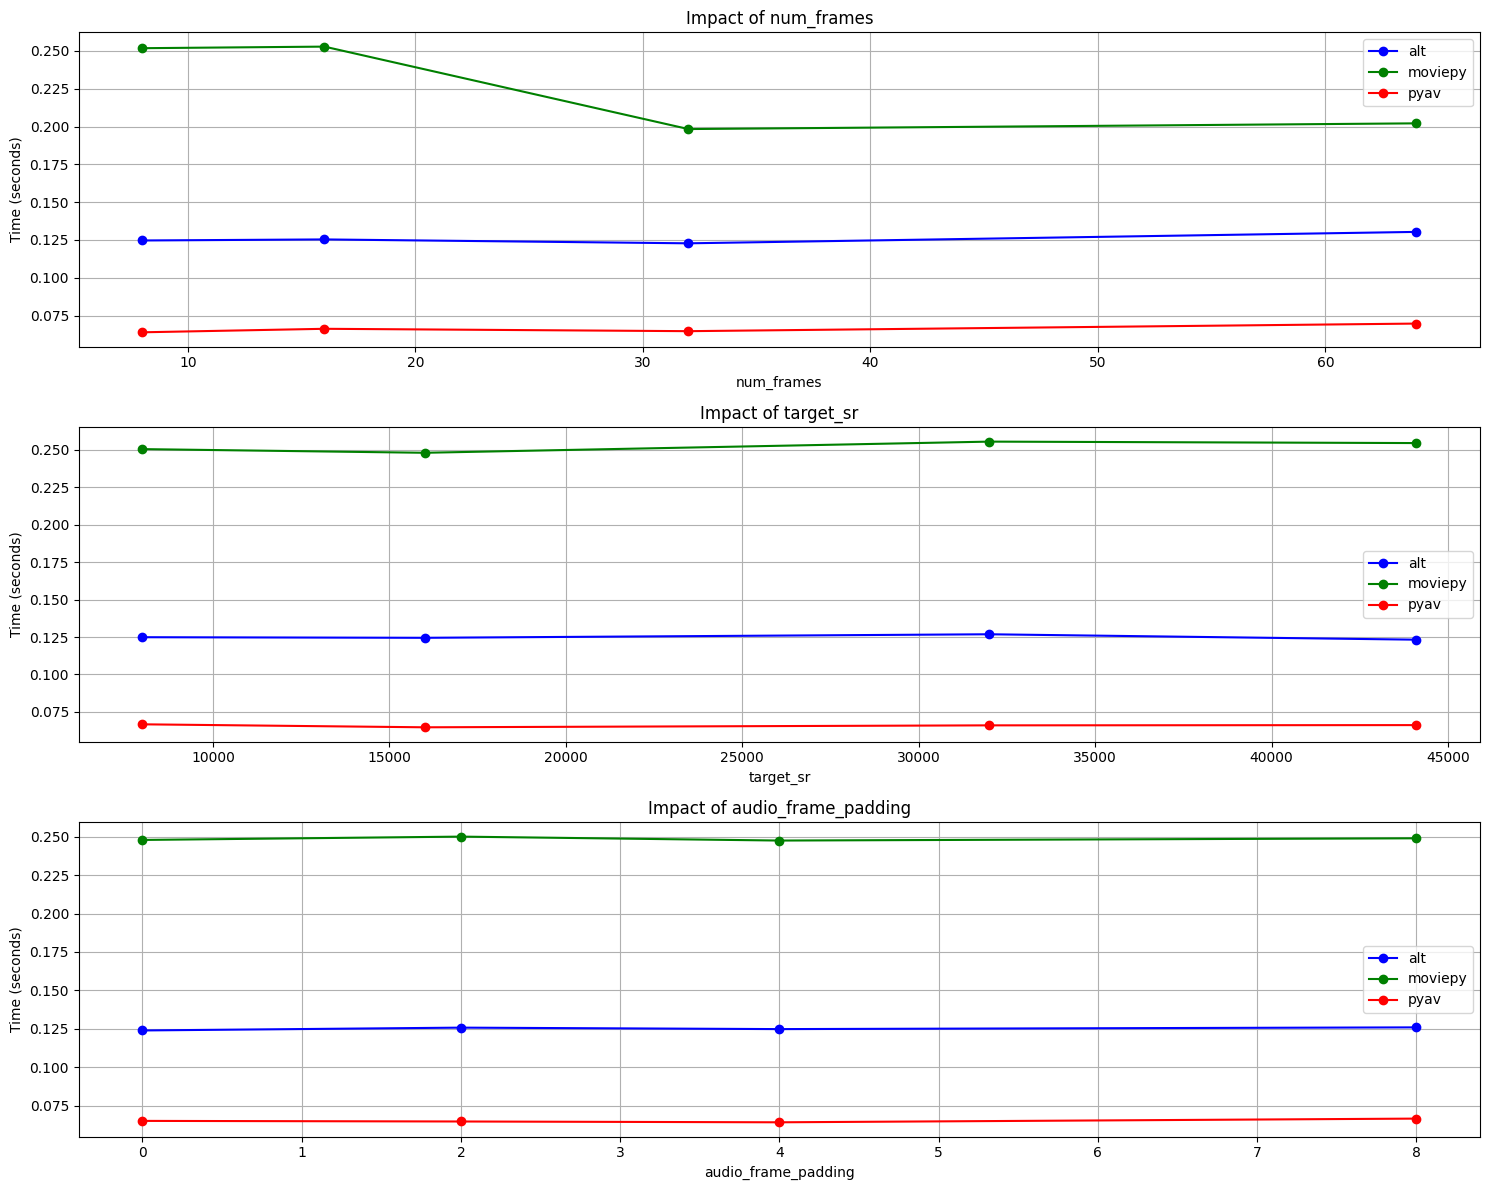

In [62]:
# Plot parameter impact results
plt.figure(figsize=(15, 12))
param_names = list(parameter_results.keys())
method_colors = {
    'alt': 'blue',
    'moviepy': 'green',
    'pyav': 'red'
}

for i, param_name in enumerate(param_names):
    plt.subplot(len(param_names), 1, i+1)
    
    # Get results for this parameter
    param_data = parameter_results[param_name]
    
    # Plot each method
    for method, color in method_colors.items():
        if method in param_data:
            # Extract data points where success=True
            values = [r['value'] for r in param_data[method] if r['success']]
            times = [r['time'] for r in param_data[method] if r['success']]
            
            if values and times:
                plt.plot(values, times, 'o-', color=color, label=method)
    
    plt.title(f'Impact of {param_name}')
    plt.xlabel(param_name)
    plt.ylabel('Time (seconds)')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'all_results' is not defined

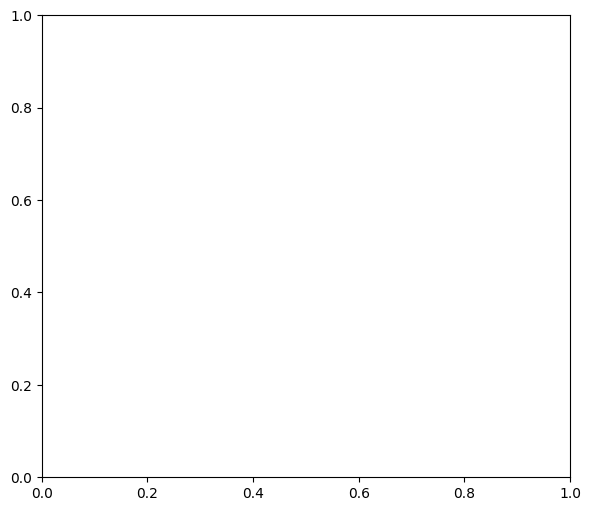

In [63]:
# Plot comparison results
plt.figure(figsize=(15, 6))

# Time comparison
plt.subplot(1, 2, 1)
times_alt = []
times_moviepy = []
labels = []

for path, results in all_results.items():
    basename = os.path.basename(path)
    if results['alt']['times'] and results['moviepy']['times']:
        times_alt.append(np.mean(results['alt']['times']))
        times_moviepy.append(np.mean(results['moviepy']['times']))
        labels.append(basename)

x = np.arange(len(labels))
width = 0.35

plt.bar(x - width/2, times_alt, width, label='Alt')
plt.bar(x + width/2, times_moviepy, width, label='MoviePy')
plt.xlabel('Video')
plt.ylabel('Time (s)')
plt.title('Execution Time Comparison')
plt.xticks(x, labels, rotation=45)
plt.legend()

# Memory comparison
plt.subplot(1, 2, 2)
memory_alt = []
memory_moviepy = []

for path, results in all_results.items():
    basename = os.path.basename(path)
    if results['alt']['memory_usage'] and results['moviepy']['memory_usage']:
        memory_alt.append(np.mean(results['alt']['memory_usage']))
        memory_moviepy.append(np.mean(results['moviepy']['memory_usage']))

plt.bar(x - width/2, memory_alt, width, label='Alt')
plt.bar(x + width/2, memory_moviepy, width, label='MoviePy')
plt.xlabel('Video')
plt.ylabel('Memory Change (MB)')
plt.title('Memory Usage Comparison')
plt.xticks(x, labels, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()